In [1]:
#Finding Putative Binding Sites Using Motifs and then Visualize them

import twobitreader as tbr
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from itertools import islice
import matplotlib.pyplot as plt

#Improvement TODO:
#I might make a fasta2twobit function in python later
#See if MEME can be incorporated into python
#probably  want to make a sequence class, pfm class, pwm class and peaks class to professionalize the code
#Fix the gzip problem
#Parallelize PWM Peak Search

#Lets start with devloping functions for reading pertinent files

#generate sequences in fasta and 2bit using biopython and twobitreader
#Don't use with gzipped files (It will unzip genome for every sequence)
#I'm going to use this function tbr to generate my sequences and revise my code
def genSeq(genome_path, chrom, chromstart, chromend):
    if bool(re.search('gz', genome_path)) | bool(re.search('fa', genome_path)) | bool(re.search('fasta', genome_path)):
        if bool(re.search('gz', genome_path)) == True:
            genome = SeqIO.parse(gzip.open(genome_path, 'rt'),'fasta')
            seq_gen = next(islice(genome, chrom , None))
            seq = str(seq_gen.seq[chromstart:chromend])
        else:
            genome = SeqIO.parse(open(genome_path),'fasta')
            seq_gen = next(islice(genome, chrom[:3] , None))
            seq = str(seq_gen.seq[chromstart:chromend])
    elif bool(re.search('2bit', genome_path)):
        tbGenome = tbr.TwoBitFile(genome_path)
        seq = tbGenome[chrom][chromstart:chromend]
    else:
        raise Exception('File type not recognized')
    return (seq).upper()

#This function will make a MEME-Chip and Homer ready fasta file for de novo motif searches
#Peaks is a path for your bed file or Narrow or Broad Peak file
#output is a output path
#The reference genome should be in twobit format (As of 2019, UCSC has twobit for most model organisms).
#This keeps the program lightweight and allows for way less memory usage. For more info click here (https://genome.ucsc.edu/goldenpath/help/twoBit.html)
#Revise with genSeq
def peak2fasta(peaks, genome, output, gzipped=False):
    f = open(output, 'w+')
    with open(peaks) as p:
        for line in p:
            if line.startswith('track') == False:
                i = list(line.split())
                f.write('>' + i[0] + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                        genSeq(genome, i[0], int(i[1]), int(i[2])) + '\n')
    if gzipped == True:
        with open(output, 'rb') as f_in, gzip.open(output + '.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    f.close()
    return "done writing file"

#Peak2Fasta for DNA2Vec
#Produce separate files for separate peaks
def peak2fasta_sep(peaks, genome, output, gzipped=False):
    with open(peaks) as p:
        for line in p:
            if line.startswith('track') == False:
                i = list(line.split())
                f = open(output + '_' + i[0] + '_' + i[1] + '_' + i[2], 'w+')
                f.write('>' + i[0] + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                        genSeq(genome, i[0], int(i[1]), int(i[2])) + '\n')
    if gzipped == True:
        with open(output, 'rb') as f_in, gzip.open(output + '.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    f.close()
    return "done writing files"

#path is a generic pfm path 
#Maybe expand to different motif formats
def read_pfm(path):
    pfm = []
    with open(path) as f:
        for line in f:
            if line.startswith('>'):
                continue
            elif re.match('^[A,C,T,G]', line):
                print('FileError: Wrong File Type')
            else:
                nuc_freqs = list(line.split())
                pfm.append(nuc_freqs)
    return np.asarray(pfm).astype(np.float)

#convert PFM to PWM
#bg is priors for all four nucleotides ACGT respectively
#pseudocount function for zero count positions
def pfm2pwm(pfm, pseudocount = 0.8, bg = [0.25, 0.25, 0.25, 0.25]):
    #chagnge into integer matrix
    pfm = np.trunc(pfm).astype(np.int)
    #Calculating Post Prob
    s = pseudocount
    bg_a = np.array(bg)
    bg_t = np.matrix(bg).transpose()
    N = np.sum(pfm[:,0])
    ppm = (pfm + (s*bg_t))/(N + s * np.sum(bg_a))
    #Calculate Weights
    norm_ppm = []
    for i in range(len(pfm)):
        norm = np.asarray(ppm[i]/(bg[i]/np.sum(bg_a))).reshape(-1)
        norm_ppm.append(norm.tolist())
    nppm = np.array(norm_ppm)
    pwm = np.log2(norm_ppm)
    return pwm

#One Hot Encoding Sequence
def oheSeq(DNAString):
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

#Creating Reverese Complements
def reverseComp(Seq):
    seq = Seq.upper()
    d = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    try:
        seq = seq[::-1]
        rc_seq = "".join([d[nuc] for nuc in seq])
    except KeyError:
        return "Not Viable DNA Seq"
    return rc_seq

#Search Sequence for sequence postion of DNA segments that match with a high enough score
def searchSeq(pwm, Seq, score, strand = '*', trim = 7):
    seqs = []
    Seq = Seq[trim:-trim]
    rc = reverseComp(Seq)
    #Normalize PWM
    max_score = sum([max(i) for i in pwm.T])
    min_score = sum([min(i) for i in pwm.T])
    n = len(pwm[0])
    unitScale = (pwm-(min_score/n))/(max_score-min_score)
    revUS = (pwm[:,::-1]-(min_score/n))/(max_score-min_score)
    #Chunk sequence into overlapping segments
    if strand == '*':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
        chunks.extend([Seq[i:i+n] for i in range(len(Seq)-n)])
    elif strand == '+':
        chunks = [Seq[i:i+n] for i in range(len(Seq)-n)]
    elif strand == '-':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
    for i in range(len(chunks)):
        OHESeq = oheSeq(chunks[i])
        seqScore = sum([np.matmul(OHESeq[j], unitScale[:,j]) for j in range(len(chunks[i]))])
        revSeqScore = sum([np.matmul(OHESeq[j], revUS[:,j]) for j in range(len(chunks[i]))])
        if seqScore >= score:
            seqs.append([chunks[i], seqScore, i-len(Seq), 'Forward'])
        if revSeqScore >= score:
            seqs.append([chunks[i], revSeqScore, i-len(Seq), 'Reverse'])
    seqs = np.array(seqs)
    if len(seqs) > 0:
        names = ['Sequence', 'Score', 'Pos', 'Orient']
        return pd.DataFrame(seqs, columns=names)
    else:
        return seqs

#Parallelizable searchSeq for ChipSeq using UCSC 2bit reader
#If you are having errors involving indexing, make sure you are using the right organism and version of your genome
#revise with genseq (will reduce the program length immensely)
def searchPeaks(pwm, peak_path, genome, score, strand = '*', threads = 1):
    names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
    motifDF = []
    motifQuant = []
    if threads == 1:
        if bool(re.search('gz', peak_path)):
            with gzip.open(peak_path, 'rt') as f:
                for line in f:
                    peak = list(line.split())
                    seq = genSeq(genome, peak[0], peak[1], peak[2])
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
        else:
            with open(peak_path) as f:
                for line in f:
                    peak = list(line.split())
                    seq = genSeq(genome, peak[0], peak[1], peak[2])
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
    else:
        return "Not Ready Yet"
    return pd.concat(motifDF), pd.DataFrame(motifQuant, columns= names)

#Genereate random sequences of length n
def randSeq(n, letters = 'ACGT'):
    code = dict((x,y) for x,y in enumerate(letters))
    encoded = np.random.randint(4, size = n)
    decode =  "".join([code[i] for i in encoded])
    return decode

#modified OHE for interspaced regions
def oheSeqMod(DNAString, flank_len):
    seq = DNAString.upper()
    flanks = seq[:6+flank_len] + seq[-6-flank_len:]
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in flanks]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.extend(letter)
    OHE.append(len(seq[6+flank_len:-6-flank_len]))
    return OHE


#Traditional PWM Search
#Takes a while currently
'''
search, dist = searchPeaks(pwm, '../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', '../data/mm10.2bit', 0.8, threads=1)
'''

#Regex Search
#Might want to combine with PWM here to explore larger Binding Site Space
'''
DR = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,10}?[AG]G[GT]TCA[AGCT]{5}'
IR = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,10}?ACT[GT]G[AG][AGCT]{5}'
ER1 = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,10}?[AG]G[GT]TCA[AGCT]{5}'
ER2 = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,10}?ACT[GT]G[AG][AGCT]{5}'
regBS = re.compile("(%s|%s|%s|%s)" % (DR,IR,ER1,ER2))
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/mm10.2bit')
with gzip.open('../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', 'rt') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2]})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)
n = 5
x = [len(i[6+n:-6-n]) for i in search_reg['binding']]
'''

#Dimensionality Reductions
'''
#euc for euclidean

euc_ohe =  np.array([oheSeqMod(i, 5) for i in search_reg['binding']])
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap  
#Be careful with umap installation pip install umap will cause you to install the wrong ver of umap (and will also break the real module)

pca = PCA(n_components=2)
pca.fit(euc_ohe)
print(pca.explained_variance_ratio_)

#Takes a bit with larger datasets (scales n^2 in both compute time and memory)
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)

#Also takes a bit (even though they claim it is faster than TSNE)
umapped = umap.UMAP().fit_transform(euc_ohe)
'''

#Graphing example
'''
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.scatter(dim1, dim2)
plt.title("OHE Mod TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()
'''
#Getting Motifs for each cluster
'''
from Bio.Seq import Seq
from Bio import motifs

#Finding the flanking sequence logo for each cluster
cluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]
cluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]
cluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]
cluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]

clusters = [cluster1, cluster2, cluster3, cluster4]
for i in range(len(clusters)):
    instances = []
    for seq in clusters[i]:
        instances.append(Seq(seq[:6+n] + seq[-6-n:]))
    m = motifs.create(instances)
    m.weblogo('../data/motif_cluster' + str(i) + '.png')
'''

"\nfrom Bio.Seq import Seq\nfrom Bio import motifs\n\n#Finding the flanking sequence logo for each cluster\ncluster1 = search_reg[search_reg['labels'] == 0].iloc[:,0]\ncluster2 = search_reg[search_reg['labels'] == 1].iloc[:,0]\ncluster3 = search_reg[search_reg['labels'] == 2].iloc[:,0]\ncluster4 = search_reg[search_reg['labels'] == 3].iloc[:,0]\n\nclusters = [cluster1, cluster2, cluster3, cluster4]\nfor i in range(len(clusters)):\n    instances = []\n    for seq in clusters[i]:\n        instances.append(Seq(seq[:6+n] + seq[-6-n:]))\n    m = motifs.create(instances)\n    m.weblogo('../data/motif_cluster' + str(i) + '.png')\n"

In [22]:
#Finding Peaks using regex
#Make regex for RGKTCA
DR = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,5}?[AG]G[GT]TCA[AGCT]{5}'
IR = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,5}?ACT[GT]G[AG][AGCT]{5}'
ER1 = '[AGCT]{5}ACT[GT]G[AG][AGCT]{1,5}?[AG]G[GT]TCA[AGCT]{5}'
ER2 = '[AGCT]{5}[AG]G[GT]TCA[AGCT]{1,5}?ACT[GT]G[AG][AGCT]{5}'
regBS = re.compile("(%s|%s|%s|%s)" % (DR,IR,ER1,ER2))
motifDF = []
motifQuant = []
genome = tbr.TwoBitFile('../data/hg38.2bit')
with open('../data/PXRChipData/rep1/SRR1642057_trim.merged.nodup_x_ctl_for_rep1.300K.bfilt.regionPeak') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'PXR'})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
genome2 = tbr.TwoBitFile('../data/mm10.2bit')
with gzip.open('../data/NR_NarrowPeaks/CAR_PB_peaks.bed.gz', 'rt') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome2[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'CAR'})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
genome3 = tbr.TwoBitFile('../data/hg38.2bit')
with open('../data/NR_NarrowPeaks/HN4A_peaks.bed') as f:
    for line in f:
        peak = list(line.split())
        seq = (genome3[peak[0]][int(peak[1]):int(peak[2])]).upper()
        rSeq = reverseComp(seq)
        sequences = []
        for result in re.finditer(regBS, seq):
            sequences.append("".join(result.groups()))
        for result in re.finditer(regBS, rSeq):
            sequences.append("".join(result.groups()))
        if len(sequences) > 0:
            seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'HN4A'})
            motifDF.append(seqs)
            motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)
genome3 = tbr.TwoBitFile('../data/hg19.2bit')
with open('../data/NR_NarrowPeaks/1739Hamner_PPARa_ucsctracks.bed') as f:
    for line in f:
        peak = list(line.split())
        if peak[0] != 'track':
            seq =(genome3[peak[0]][int(peak[1]):int(peak[2])]).upper()
            rSeq = reverseComp(seq)
            sequences = []
            for result in re.finditer(regBS, seq):
                sequences.append("".join(result.groups()))
            for result in re.finditer(regBS, rSeq):
                sequences.append("".join(result.groups()))
            if len(sequences) > 0:
                seqs = pd.DataFrame({'binding':sequences, 'chrom':peak[0], 'chromstart':peak[1], 'chromend':peak[2], 'NR':'PPAR'})
                motifDF.append(seqs)
                motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
search_reg = pd.concat(motifDF)
names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
dist_reg = pd.DataFrame(motifQuant, columns=names)

In [17]:
search_reg['binding']['NR'=='PPARA']

,binding,chrom,chromstart,chromend,NR
0,ATATGAGTTCAGAAAGTTCAGAAAG,chr7,75920652,75920848,PXR
0,GCAGAGGGTCAGCAAGTTCATTCAG,chr7,99791731,99791927,PXR
0,TTGCTGGGTCAGGGCAGGTTCACAGCC,chr2,100883242,100883438,PXR
0,AACCAAGGTCAGAAGGGTTCAGTGAC,chr16,82082854,82083050,PXR
0,TCCTGGGTTCAAGCGAGTTCATCAGG,chr1,236850691,236850887,PXR
0,TGGACACTTGGTTAGGTCATCTGA,chr6,87671741,87671937,PXR
0,GCAGAGGGTCAGCAAGTTCATTCAG,chr7,99742763,99742959,PXR
0,CTTCGGGGTCAGGGGAGGTCAGGAAG,chr18,58400081,58400277,PXR
0,AGCAAAGGTCAGTAGAGTTCAGAGCT,chr17,16285945,16286141,PXR
0,GCTCTGGGTCAACTGAGGTCAGAAGA,chr4,184104481,184104677,PXR


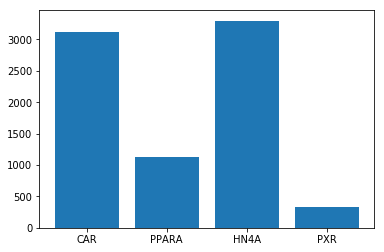

In [24]:
#Bar Graph of binding sites
xs = []
for i in ['CAR', 'PPAR', 'HN4A', 'PXR']:
    xs.append([len(j) for j in search_reg['binding'][search_reg['NR']==i]])
plt.bar(x = [1,2,3,4], height = [len(i) for i in xs], tick_label = ['CAR', 'PPARA', 'HN4A', 'PXR'])
plt.savefig('../figs/PeakDist.tif', dpi = 600)
plt.show()

In [25]:
### Importing DNA2Vec Encoding ###
## Multi K Model from DNA2Vec Github ##
from __future__ import print_function

import logbook
import tempfile
import numpy as np

from gensim.models import word2vec
from gensim import matutils
from gensim.models import KeyedVectors

class SingleKModel:
    def __init__(self, model):
        self.model = model
        self.vocab_lst = sorted(model.vocab.keys())

class MultiKModel:
    def __init__(self, filepath):
        self.aggregate = KeyedVectors.load_word2vec_format(filepath, binary=False)
        self.logger = logbook.Logger(self.__class__.__name__)

        vocab_lens = [len(vocab) for vocab in self.aggregate.vocab.keys()]
        self.k_low = min(vocab_lens)
        self.k_high = max(vocab_lens)
        self.vec_dim = self.aggregate.vector_size

        self.data = {}
        for k in range(self.k_low, self.k_high + 1):
            self.data[k] = self.separate_out_model(k)

    def model(self, k_len):
        """
        Use vector('ACGTA') when possible
        """
        return self.data[k_len].model

    def vector(self, vocab):
        return self.data[len(vocab)].model[vocab]

    def unitvec(self, vec):
        return matutils.unitvec(vec)

    def cosine_distance(self, vocab1, vocab2):
        return np.dot(self.unitvec(self.vector(vocab1)), self.unitvec(self.vector(vocab2)))

    def l2_norm(self, vocab):
        return np.linalg.norm(self.vector(vocab))

    def separate_out_model(self, k_len):
        vocabs = [vocab for vocab in self.aggregate.vocab.keys() if len(vocab) == k_len]
        if len(vocabs) != 4 ** k_len:
            self.logger.warn('Missing {}-mers: {} / {}'.format(k_len, len(vocabs), 4 ** k_len))

        header_str = '{} {}'.format(len(vocabs), self.vec_dim)
        with tempfile.NamedTemporaryFile(mode='w') as fptr:
            print(header_str, file=fptr)
            for vocab in vocabs:
                vec_str = ' '.join("%f" % val for val in self.aggregate[vocab])
                print('{} {}'.format(vocab, vec_str), file=fptr)
            fptr.flush()
            return SingleKModel(KeyedVectors.load_word2vec_format(fptr.name, binary=False))

In [26]:
### Defining Encoding Function ###
def w2vEncode(string, model, flank_len):
    enc = []
    flank1 = string[:flank_len]
    motif1 = string[flank_len:flank_len+6]
    inter = string[flank_len+6:-6-flank_len]
    motif2 = string[-flank_len-6:-flank_len]
    flank2 = string[-flank_len:]
    bsStruct = [flank1, motif1, inter, motif2, flank2]
    for i in bsStruct:
        e = model.vector(i).tolist()
        enc.extend(e)
    return np.array(enc)

In [46]:
## Testing Encoding Recall ##
wg_
euchromatin = MultiKModel(OCfile)
hn4aP = MultiKModel(hn4afile)

In [47]:
oc_w2v =  np.array([w2vEncode(i, euchromatin, 5) for i in search_reg['binding']])
oc_w2v_car = np.array([w2vEncode(i, euchromatin, 5) for i in search_reg['binding'][search_reg['NR']=='CAR']])
oc_w2v_ppar = np.array([w2vEncode(i, euchromatin, 5) for i in search_reg['binding'][search_reg['NR']=='PPARA']])
oc_w2v_hn4a = np.array([w2vEncode(i, euchromatin, 5) for i in search_reg['binding'][search_reg['NR']=='HN4A']])

p_w2v =  np.array([w2vEncode(i, hn4aP, 5) for i in search_reg['binding']])
p_w2v_car = np.array([w2vEncode(i, hn4aP, 5) for i in search_reg['binding'][search_reg['NR']=='CAR']])
p_w2v_ppar = np.array([w2vEncode(i, hn4aP, 5) for i in search_reg['binding'][search_reg['NR']=='PPARA']])
p_w2v_hn4a = np.array([w2vEncode(i, hn4aP, 5) for i in search_reg['binding'][search_reg['NR']=='HN4A']])

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap  

In [73]:
pca = PCA(n_components=2)
pcac = PCA(n_components=2)
pcap = PCA(n_components=2)
pcah = PCA(n_components=2)
pca.fit(oc_w2v)
pcac.fit(oc_w2v_car)
pcap.fit(oc_w2v_ppar)
pcah.fit(oc_w2v_hn4a)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

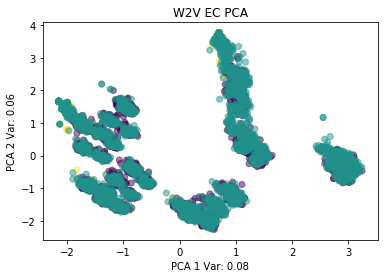

In [50]:
NR = search_reg['NR'].astype('category').cat.codes
pca_coord = pca.transform(oc_w2v)
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
plt.scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
plt.title("W2V EC PCA")
plt.xlabel('PCA 1 Var: ' + str(pca.explained_variance_ratio_[0])[:4])
plt.ylabel('PCA 2 Var: '+ str(pca.explained_variance_ratio_[1])[:4])
plt.savefig('../figs/OcW2vPCA.tif', dpi = 600)
plt.show()

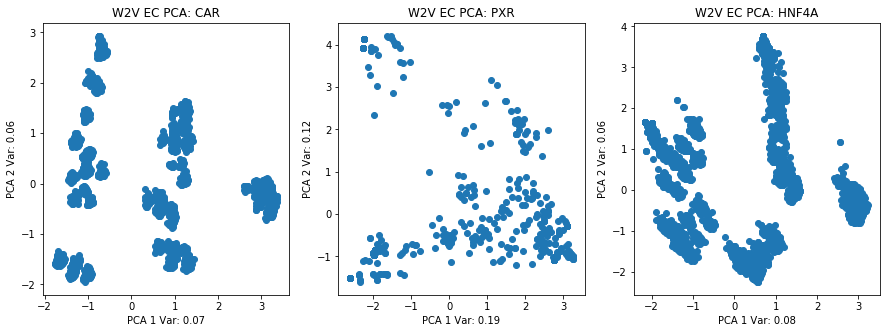

In [74]:
#PCA Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
pcac_coord = pcac.transform(oc_w2v_car)
dim1c = pcac_coord[:, 0]
dim2c = pcac_coord[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V EC PCA: CAR")
ax[0].set_xlabel('PCA 1 Var: ' + str(pcac.explained_variance_ratio_[0])[:4])
ax[0].set_ylabel('PCA 2 Var: '+ str(pcac.explained_variance_ratio_[1])[:4])
#PPAR
pcap_coord = pcap.transform(oc_w2v_ppar)
dim1p = pcap_coord[:, 0]
dim2p = pcap_coord[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V EC PCA: PXR")
ax[1].set_xlabel('PCA 1 Var: ' + str(pcap.explained_variance_ratio_[0])[:4])
ax[1].set_ylabel('PCA 2 Var: '+ str(pcap.explained_variance_ratio_[1])[:4])
#HN4A
pcah_coord = pca.transform(oc_w2v_hn4a)
dim1h = pcah_coord[:, 0]
dim2h = pcah_coord[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V EC PCA: HNF4A")
ax[2].set_xlabel('PCA 1 Var: ' + str(pcah.explained_variance_ratio_[0])[:4])
ax[2].set_ylabel('PCA 2 Var: '+ str(pcah.explained_variance_ratio_[1])[:4])
fig.savefig('../figs/IndOcW2vPCA.tif', dpi = 600)
plt.show()

In [54]:
pca = PCA(n_components=2)
pcac = PCA(n_components=2)
pcap = PCA(n_components=2)
pcah = PCA(n_components=2)
pca.fit(p_w2v)
pcac.fit(p_w2v_car)
pcap.fit(p_w2v_ppar)
pcah.fit(p_w2v_hn4a)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [55]:
print(pca.explained_variance_ratio_)

[0.08352466 0.0614614 ]


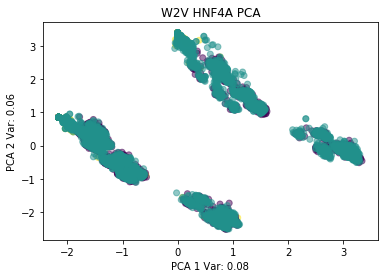

In [58]:
NR = search_reg['NR'].astype('category').cat.codes
pca_coord = pca.transform(p_w2v)
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
plt.scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
plt.title("W2V HNF4A PCA")
plt.xlabel('PCA 1 Var: ' + str(pca.explained_variance_ratio_[0])[:4])
plt.ylabel('PCA 2 Var: '+ str(pca.explained_variance_ratio_[1])[:4])
plt.savefig('../hn4aW2vPCA.tif', dpi = 600)
plt.show()

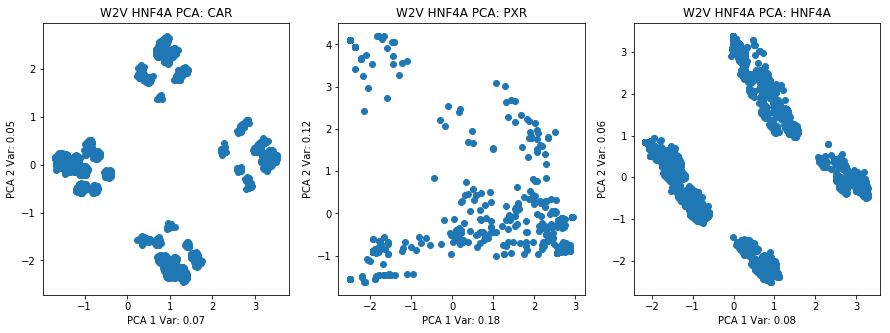

In [59]:
#PCA Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
pcac_coord = pcac.transform(p_w2v_car)
dim1c = pcac_coord[:, 0]
dim2c = pcac_coord[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V HNF4A PCA: CAR")
ax[0].set_xlabel('PCA 1 Var: ' + str(pcac.explained_variance_ratio_[0])[:4])
ax[0].set_ylabel('PCA 2 Var: '+ str(pcac.explained_variance_ratio_[1])[:4])
#PPAR
pcap_coord = pcap.transform(p_w2v_ppar)
dim1p = pcap_coord[:, 0]
dim2p = pcap_coord[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V HNF4A PCA: PXR")
ax[1].set_xlabel('PCA 1 Var: ' + str(pcap.explained_variance_ratio_[0])[:4])
ax[1].set_ylabel('PCA 2 Var: '+ str(pcap.explained_variance_ratio_[1])[:4])
#HNF4A
pcah_coord = pca.transform(p_w2v_hn4a)
dim1h = pcah_coord[:, 0]
dim2h = pcah_coord[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V HNF4A PCA: HNF4A")
ax[2].set_xlabel('PCA 1 Var: ' + str(pcah.explained_variance_ratio_[0])[:4])
ax[2].set_ylabel('PCA 2 Var: '+ str(pcah.explained_variance_ratio_[1])[:4])
fig.savefig('../figs/IndHnf4aW2vPCA.tif', dpi = 600)
plt.show()

In [60]:
ec_embedded = TSNE(n_components=2).fit_transform(oc_w2v)
ec_car = TSNE(n_components=2).fit_transform(oc_w2v_car)
ec_ppar = TSNE(n_components=2).fit_transform(oc_w2v_ppar)
ec_hn4a = TSNE(n_components=2).fit_transform(oc_w2v_hn4a)

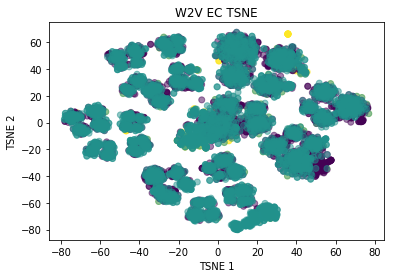

In [62]:
dim1 = ec_embedded[:, 0]
dim2 = ec_embedded[:, 1]
plt.scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
plt.title("W2V EC TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.savefig('../figs/OcTSNE.tif', dpi = 600)
plt.show()

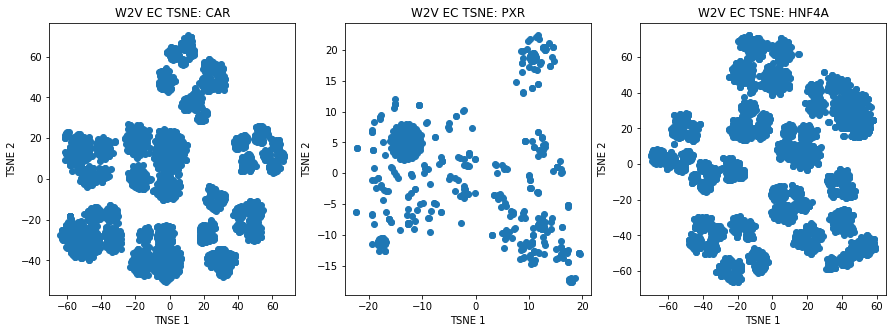

In [72]:
#TSNE Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = ec_car[:, 0]
dim2c = ec_car[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V EC TSNE: CAR")
ax[0].set_xlabel('TNSE 1')
ax[0].set_ylabel('TSNE 2')
#PPAR
dim1p = ec_ppar[:, 0]
dim2p = ec_ppar[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V EC TSNE: PXR")
ax[1].set_xlabel('TSNE 1')
ax[1].set_ylabel('TSNE 2')
#HN4A
dim1h = ec_hn4a[:, 0]
dim2h = ec_hn4a[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V EC TSNE: HNF4A")
ax[2].set_xlabel('TSNE 1')
ax[2].set_ylabel('TSNE 2')
fig.savefig('../figs/IndOcTSNE.tif', dpi = 600)
plt.show()

In [65]:
p_embedded = TSNE(n_components=2).fit_transform(p_w2v)
p_car = TSNE(n_components=2).fit_transform(p_w2v_car)
p_ppar = TSNE(n_components=2).fit_transform(p_w2v_ppar)
p_hn4a = TSNE(n_components=2).fit_transform(p_w2v_hn4a)

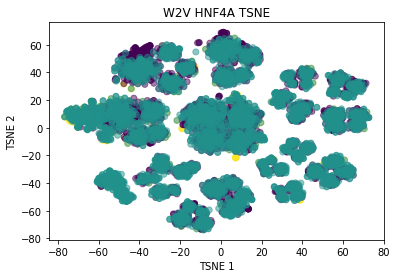

In [66]:
dim1 = p_embedded[:, 0]
dim2 = p_embedded[:, 1]
plt.scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
plt.title("W2V HNF4A TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.savefig('../figs/hnf4aTSNE.tif', dpi = 600)
plt.show()

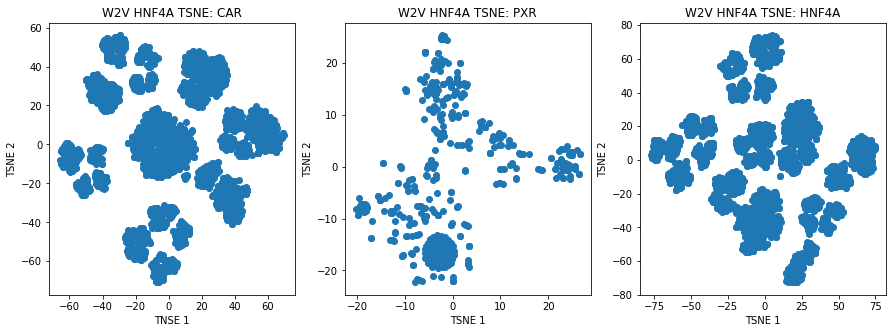

In [67]:
#TSNE Projections for individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = p_car[:, 0]
dim2c = p_car[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V HNF4A TSNE: CAR")
ax[0].set_xlabel('TNSE 1')
ax[0].set_ylabel('TSNE 2')
#PPAR
dim1p = p_ppar[:, 0]
dim2p = p_ppar[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V HNF4A TSNE: PXR")
ax[1].set_xlabel('TSNE 1')
ax[1].set_ylabel('TSNE 2')
#HN4A
dim1h = p_hn4a[:, 0]
dim2h = p_hn4a[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V HNF4A TSNE: HNF4A")
ax[2].set_xlabel('TSNE 1')
ax[2].set_ylabel('TSNE 2')
fig.savefig('../figs/IndHnf4aTSNE.tif', dpi = 600)
plt.show()

In [68]:
umapped = umap.UMAP().fit_transform(oc_w2v)
umapc = umap.UMAP().fit_transform(oc_w2v_car)
umapp = umap.UMAP().fit_transform(oc_w2v_ppar)
umaph = umap.UMAP().fit_transform(oc_w2v_hn4a)

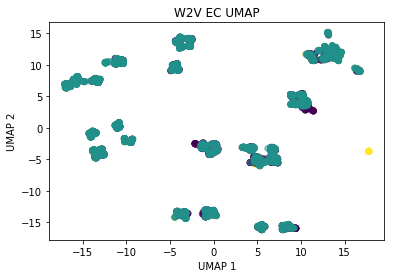

In [69]:
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
plt.scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
plt.title("W2V EC UMAP")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('../figs/OcW2vUmap.tif', dpi = 600)
plt.show()

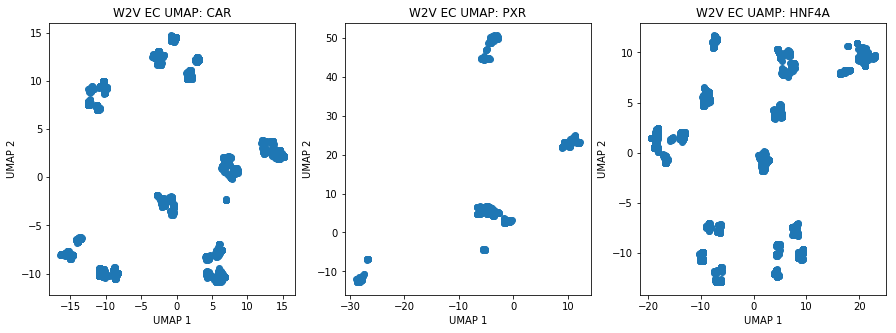

In [71]:
#UMAP Projections of individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = umapc[:, 0]
dim2c = umapc[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V EC UMAP: CAR")
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
#PPAR
dim1p = umapp[:, 0]
dim2p = umapp[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V EC UMAP: PXR")
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
#HN4A
dim1h = umaph[:, 0]
dim2h = umaph[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V EC UAMP: HNF4A")
ax[2].set_xlabel('UMAP 1')
ax[2].set_ylabel('UMAP 2')
fig.savefig('../figs/IndOcW2vUmap.tif', dpi = 600)
plt.show()

In [75]:
umappedp = umap.UMAP().fit_transform(p_w2v)
umapcp = umap.UMAP().fit_transform(p_w2v_car)
umappp = umap.UMAP().fit_transform(p_w2v_ppar)
umaphp = umap.UMAP().fit_transform(p_w2v_hn4a)

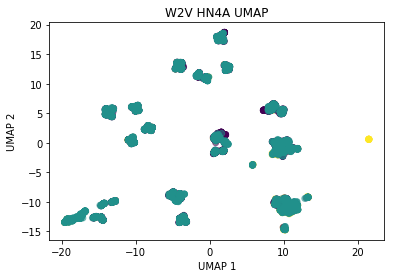

In [76]:
dim1 = umappedp[:, 0]
dim2 = umappedp[:, 1]
plt.scatter(dim1, dim2, c=NR, cmap='viridis', alpha=0.5)
plt.title("W2V HN4A UMAP")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('../figs/hnf4aW2vUmap.tif', dpi = 600)
plt.show()

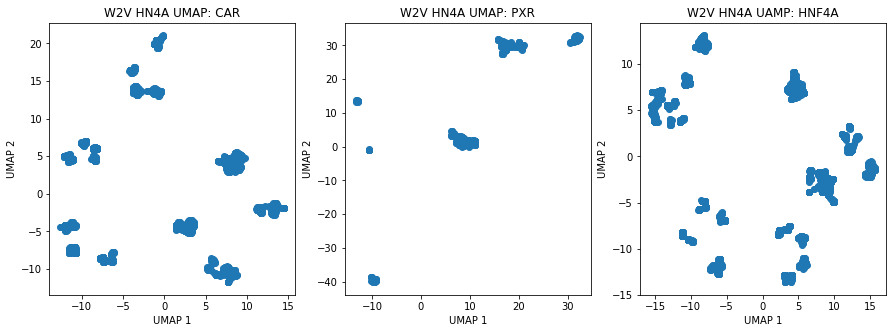

In [77]:
#UMAP Projections of individual TF
fig, ax = plt.subplots(1,3, figsize=[15,5])
#CAR
dim1c = umapcp[:, 0]
dim2c = umapcp[:, 1]
ax[0].scatter(dim1c, dim2c)
ax[0].set_title("W2V HN4A UMAP: CAR")
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
#PPAR
dim1p = umappp[:, 0]
dim2p = umappp[:, 1]
ax[1].scatter(dim1p, dim2p)
ax[1].set_title("W2V HN4A UMAP: PXR")
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
#HN4A
dim1h = umaphp[:, 0]
dim2h = umaphp[:, 1]
ax[2].scatter(dim1h, dim2h)
ax[2].set_title("W2V HN4A UAMP: HNF4A")
ax[2].set_xlabel('UMAP 1')
ax[2].set_ylabel('UMAP 2')
plt.savefig('../figs/IndHnf4aW2vUmap.tif', dpi = 600)
plt.show()

In [322]:
# Word2Vec Visualization
w2v_agn = pd.read_csv('../data/hg38/dna2vec-20190508-1815-k1to8-100d-10c-31500Mbp-sliding-czf.w2v', header = None, delim_whitespace = True, skiprows = 1, engine = 'c')
w2v_words = w2v_agn.iloc[:, 0].values
w2v_vecs = w2v_agn.iloc[:, 1:].values
w2v_agn = []

[0.05364849 0.02995797]
0.772976058420468


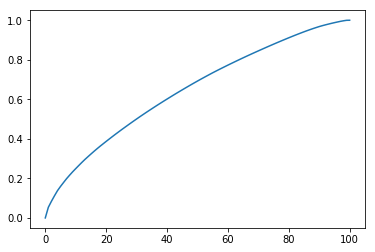

In [323]:
# PCA
PCAFULL = PCA()
pca.fit(w2v_vecs)
PCAFULL.fit(w2v_vecs)
print(pca.explained_variance_ratio_)
w2v_pca = pca.transform(w2v_vecs)
var = PCAFULL.explained_variance_ratio_
var_sum = 0
cum_var = [0]
for i in var:
    var_sum += i
    cum_var.append(var_sum)
print(cum_var[60])
plt.plot(cum_var)
plt.show()

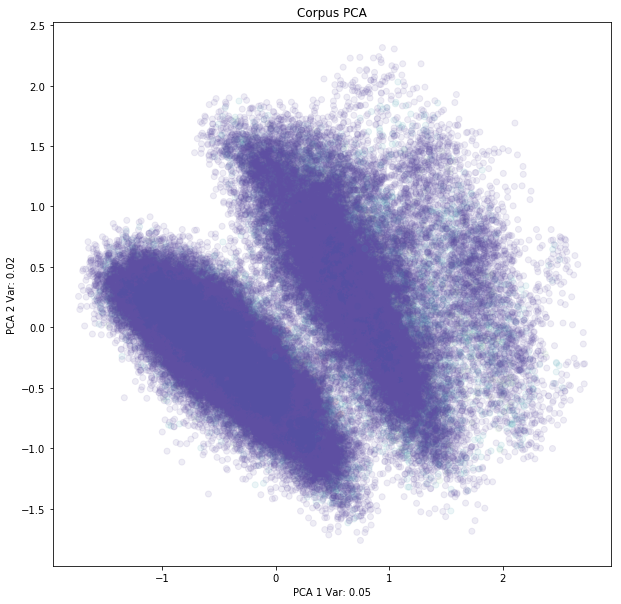

In [325]:
# PCA didn't work, but I'll plot it
dim1 = w2v_pca[:, 0]
dim2 = w2v_pca[:, 1]
lens = [len(i) for i in w2v_words]
plt.figure(figsize = [10, 10])
plt.scatter(dim1, dim2, c = lens, cmap='Spectral', alpha=0.1)
plt.title("Corpus PCA")
plt.xlabel('PCA 1 Var: '+ str(pca.explained_variance_ratio_[0])[:4])
plt.ylabel('PCA 2 Var: '+ str(pca.explained_variance_ratio_[1])[:4])
plt.show()

In [326]:
#Lets try UMAP
umapped = umap.UMAP().fit_transform(w2v_vecs)

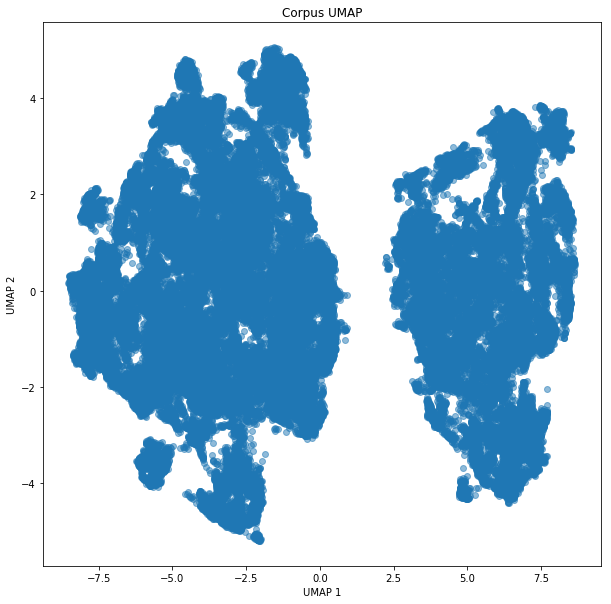

In [328]:
dim1 = umapped[:, 0]
dim2 = umapped[:, 1]
plt.figure(figsize=[10,10])
plt.scatter(dim1, dim2, alpha=0.5)
plt.title("Corpus UMAP")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [330]:
#Lets Try TSNE
ctsne = TSNE(n_components = 2).fit_transform(w2v_vecs)

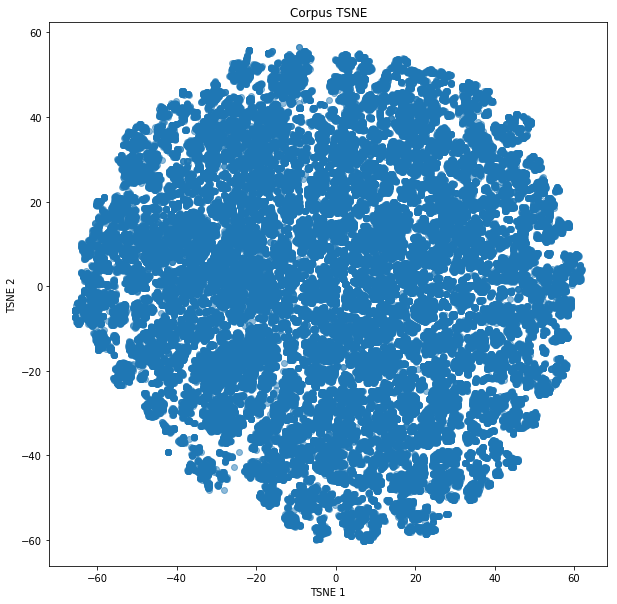

In [331]:
dim1 = ctsne[:, 0]
dim2 = ctsne[:, 1]
plt.figure(figsize=[10,10])
plt.scatter(dim1, dim2, alpha=0.5)
plt.title("Corpus TSNE")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()